In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [24]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")  
test_df = pd.read_csv("test.csv") 

In [25]:
train_df

,Label,Message
0,0,thats cool day
1,0,work ah den plus lor workin oso rite den go or...
2,0,hi email address changed
3,0,uncle checking rewarding month
4,0,ok ive sent da latest version da project
...,...,...
3824,0,know wot people wear shirts jumpers hat belt k...
3825,0,lol boo hoping laugh
3826,1,message brought gmw ltd connected
3827,0,probs hon doinat mo


In [26]:
X_train, y_train = train_df["Message"], train_df["Label"]
X_val, y_val = val_df["Message"], val_df["Label"]
X_test, y_test = test_df["Message"], test_df["Label"]


In [27]:
# Convert Text into TF-IDF Features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [36]:
# Define Multiple Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=21),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=21),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(probability=True, random_state=21),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=21)
}

# Train and Evaluate Each Model
best_model = None
best_score = 0
model_scores = {}

def train_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):  # If the model supports probability prediction
        y_prob = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_prob = model.decision_function(X_test_tfidf)  # For SVM
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    
    # Scoring
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    model_scores[model.__class__.__name__] = val_score

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Evaluation
    print(f"\n🔹 Model: {model.__class__.__name__}")
    print(f"✅ Train Accuracy: {train_score:.4f}")
    print(f"📊 Validation Accuracy: {val_score:.4f}")

    print("📌 Classification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.show()

    return val_score  # Return Validation Score


🔹 Model: LogisticRegression
✅ Train Accuracy: 0.9637
📊 Validation Accuracy: 0.9482
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       558
           1       0.94      0.62      0.75        79

    accuracy                           0.95       637
   macro avg       0.95      0.81      0.86       637
weighted avg       0.95      0.95      0.94       637



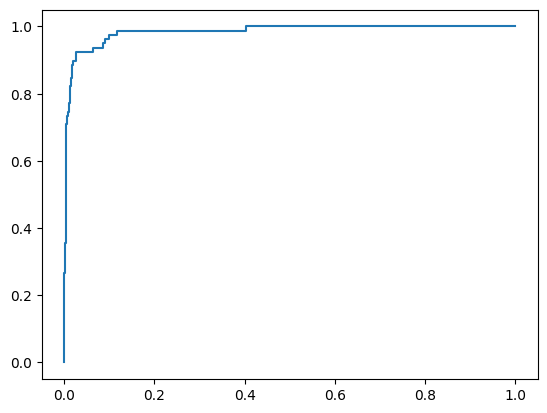

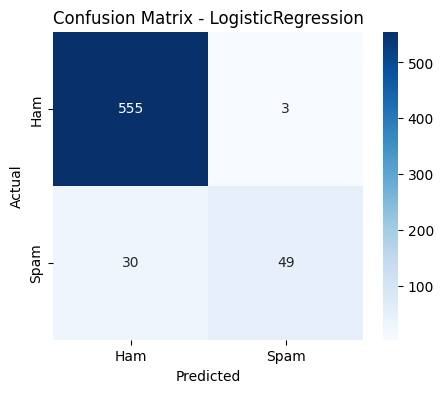


🔹 Model: RandomForestClassifier
✅ Train Accuracy: 1.0000
📊 Validation Accuracy: 0.9655
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       1.00      0.72      0.84        79

    accuracy                           0.97       637
   macro avg       0.98      0.86      0.91       637
weighted avg       0.97      0.97      0.96       637



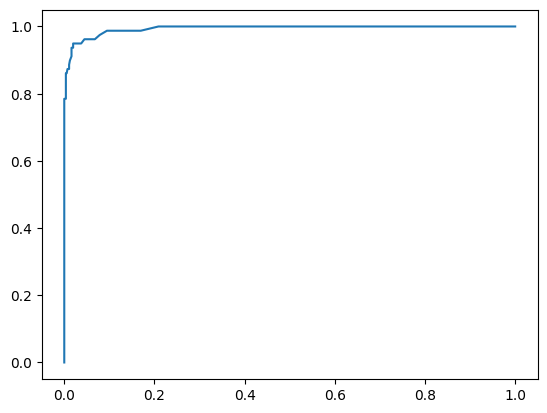

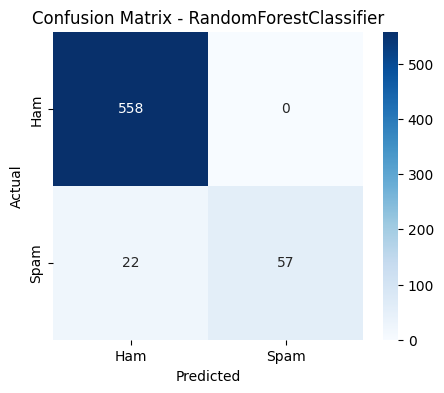


🔹 Model: MultinomialNB
✅ Train Accuracy: 0.9791
📊 Validation Accuracy: 0.9592
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       1.00      0.67      0.80        79

    accuracy                           0.96       637
   macro avg       0.98      0.84      0.89       637
weighted avg       0.96      0.96      0.96       637



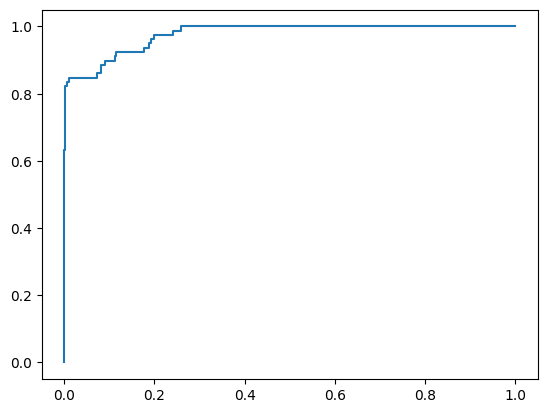

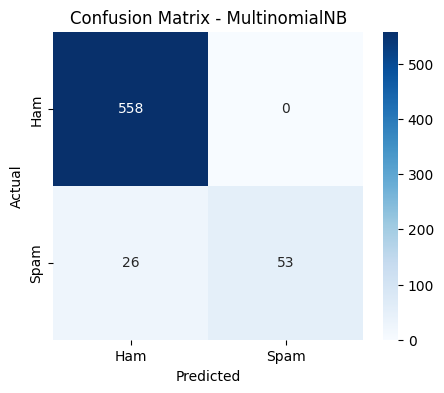


🔹 Model: SVC
✅ Train Accuracy: 0.9979
📊 Validation Accuracy: 0.9623
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       0.97      0.72      0.83        79

    accuracy                           0.96       637
   macro avg       0.96      0.86      0.90       637
weighted avg       0.96      0.96      0.96       637



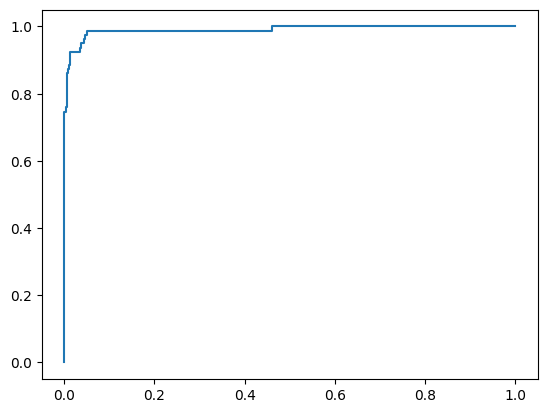

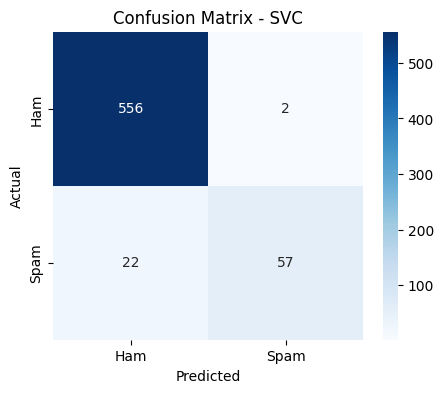


🔹 Model: XGBClassifier
✅ Train Accuracy: 0.9890
📊 Validation Accuracy: 0.9576
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       558
           1       0.91      0.73      0.81        79

    accuracy                           0.96       637
   macro avg       0.93      0.86      0.89       637
weighted avg       0.96      0.96      0.96       637



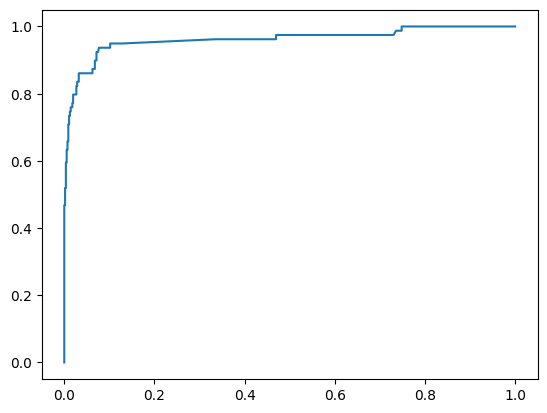

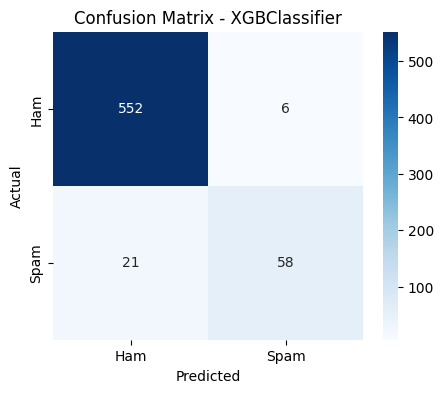


🏆 Best Model Selected: RandomForestClassifier


In [37]:
# Train and Evaluate All Models
for name, model in models.items():
    score = train_evaluate_model(model, X_train_tfidf, y_train, X_val_tfidf, y_val)
    if score > best_score:
        best_score = score
        best_model = model

print(f"\n🏆 Best Model Selected: {best_model.__class__.__name__}")